In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm

# Assumption
If we make the S2 variance infinity its precision would be 0, so it would be eleminated from MAP. By that the agent would compate MAP(s1) to its mean only and the threshold value of the psychometric would be the prior mean

In [2]:
def gumbal(x,x0,b):
    #reparam of gumbal as 10^(b(x-a) = e(ln(10)(b(x-a)))
    #from https://palamedestoolbox.org/weibullandfriends.html
    return  1 - np.exp(-np.exp(b*(x-x0)))

In [3]:
def cum_gauss(x, mu, sigma):
    return norm.cdf((x - mu) / sigma)

In [4]:
def logistic(x, mu, s):
    # classic logistic psychometric
    return 1.0 / (1.0 + np.exp(-(x - mu) / s))

In [5]:
file = "combined_psychometric_data_mean.csv"
stims = "S1_val"
choice = "P_choose1"

In [6]:
df = pd.read_csv(file)
required_cols = {"S1_std", "S2_std", "S1_val", "S2_val", "P_choose1", "N_trials"}

In [7]:
def binomial_loglik(k, n, p):
    # avoid log(0)
    eps = 1e-9
    p = np.clip(p, eps, 1 - eps)
    return np.sum(k * np.log(p) + (n - k) * np.log(1 - p))

def fit_model(x, p, n, model, p0, bounds):
    # fit on probabilities (least squares)
    params, pcov = curve_fit(model, x, p, p0=p0, bounds=bounds, maxfev=20000)
    p_hat = model(x, *params)
    ll = binomial_loglik(np.round(p * n).astype(int), n, p_hat)
    k_params = len(params)
    aic = 2 * k_params - 2 * ll
    return params, aic, p_hat

In [8]:
# df is the combined psychometric data:
# columns expected: S1_val, S1_std, P_choose1, N_trials

# Pool across S1_std: weighted by number of trials
group_pool = (
    df.groupby("S1_val")
      .apply(lambda g: pd.Series({
          "P_choose1": np.average(g["P_choose1"], weights=g["N_trials"]),
          "N_trials":  g["N_trials"].sum()
      }))
      .reset_index()
)

x_data = group_pool["S1_val"].values.astype(float)
p_data = group_pool["P_choose1"].values.astype(float)
n_data = group_pool["N_trials"].values.astype(int)
k_data = np.round(p_data * n_data).astype(int)   # approximate counts

# sanity check: monotonic-ish
print(group_pool.head())

   S1_val  P_choose1  N_trials
0    -4.0    0.02735   20000.0
1    -3.9    0.03085   20000.0
2    -3.8    0.03295   20000.0
3    -3.7    0.03810   20000.0
4    -3.6    0.04340   20000.0


/var/folders/s4/z3qm0kcs63v02zyrflt62gq80000gn/T/ipykernel_52859/3813649998.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [9]:
# initial guesses: threshold ~ where p ~ 0.5
idx50 = np.argmin(np.abs(p_data - 0.5))
mu_guess = x_data[idx50]
# --- Probit ---
probit_params, probit_aic, probit_p = fit_model(
    x_data, p_data, n_data,
    model=cum_gauss,
    p0=[mu_guess, 1.0],
    bounds=([-np.inf, 1e-4], [np.inf, np.inf])
)
mu_probit, sigma_probit = probit_params

# --- Logistic ---
logit_params, logit_aic, logit_p = fit_model(
    x_data, p_data, n_data,
    model=logistic,
    p0=[mu_guess, 1.0],
    bounds=([-np.inf, 1e-4], [np.inf, np.inf])
)
mu_logit, s_logit = logit_params

# --- Gumbel ---
# for Gumbel, x0 ~ threshold-ish, b small-ish
gumbel_params, gumbel_aic, gumbel_p = fit_model(
    x_data, p_data, n_data,
    model=gumbal,
    p0=[mu_guess, 1.0],
    bounds=([-np.inf, 1e-4], [np.inf, np.inf])
)
x0_gumbel, b_gumbel = gumbel_params


# PSE for gumbel: solve Psi(x) = 0.5 → exp(b(x-x0)) = ln(2)
x50_gumbel = x0_gumbel + np.log(np.log(2.0)) / b_gumbel

print("\n=== SINGLE-FIT MODEL COMPARISON ===")
print(f"Probit:   mu={mu_probit:.4f}, sigma={sigma_probit:.4f}, AIC={probit_aic:.2f}")
print(f"Logistic: mu={mu_logit:.4f}, s={s_logit:.4f},          AIC={logit_aic:.2f}")
print(f"Gumbel:   x0={x0_gumbel:.4f}, b={b_gumbel:.4f}, x50={x50_gumbel:.4f}, AIC={gumbel_aic:.2f}")


=== SINGLE-FIT MODEL COMPARISON ===
Probit:   mu=-0.8161, sigma=1.5870, AIC=1133244.12
Logistic: mu=-0.8170, s=0.9373,          AIC=1133432.21
Gumbel:   x0=-0.1894, b=0.7337, x50=-0.6889, AIC=1190568.34


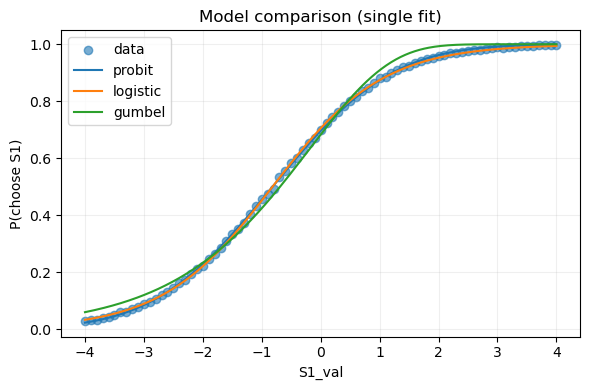

In [10]:
xx = np.linspace(x_data.min(), x_data.max(), 400)
plt.figure(figsize=(6,4))
plt.scatter(x_data, p_data, label="data", alpha=0.6)
plt.plot(xx, cum_gauss(xx, *probit_params), label="probit")
plt.plot(xx, logistic(xx, *logit_params), label="logistic")
plt.plot(xx, gumbal(xx, *gumbel_params), label="gumbel")
plt.xlabel("S1_val")
plt.ylabel("P(choose S1)")
plt.title("Model comparison (single fit)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [11]:
n_boot = 1000  

mu_boot_probit = []
mu_boot_logit  = []
mu_boot_gumbel = []

rng = np.random.default_rng(42)

for b in range(n_boot):
    # resample counts per S1_val
    k_boot = rng.binomial(n=n_data, p=p_data)
    p_boot = k_boot / n_data

    # skip weird cases
    if (p_boot <= 0).all() or (p_boot >= 1).all():
        continue

    try:
        params_p, _, _ = fit_model(
            x_data, p_boot, n_data,
            model=cum_gauss,
            p0=[mu_probit, sigma_probit],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf])
        )
        mu_b, sigma_b = params_p
        mu_boot_probit.append(mu_b)
    except Exception:
        continue

    try:
        params_l, _, _ = fit_model(
            x_data, p_boot, n_data,
            model=logistic,
            p0=[mu_logit, s_logit],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf])
        )
        mu_b, s_b = params_l
        mu_boot_logit.append(mu_b)
    except Exception:
        continue

    try:
        params_g, _, _ = fit_model(
            x_data, p_boot, n_data,
            model=gumbal,
            p0=[x0_gumbel, b_gumbel],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf])
        )
        x0_b, b_b = params_g
        x50_b = x0_b + np.log(np.log(2.0)) / b_b
        mu_boot_gumbel.append(x50_b)
    except Exception:
        continue

print(f"\nBootstraps kept: probit={len(mu_boot_probit)}, "
      f"logit={len(mu_boot_logit)}, gumbel={len(mu_boot_gumbel)}")


Bootstraps kept: probit=1000, logit=1000, gumbel=1000


In [12]:
def summarize(name, samples):
    samples = np.asarray(samples)
    m  = samples.mean()
    sd = samples.std()
    lo, hi = np.percentile(samples, [2.5, 97.5])
    print(f"{name}: mean={m:.4f}, sd={sd:.4f}, 95% CI [{lo:.4f}, {hi:.4f}]")

print("\n=== BOOTSTRAP PRIOR MEAN ESTIMATES ===")
summarize("Probit  μ50",  mu_boot_probit)
summarize("Logistic μ50", mu_boot_logit)
summarize("Gumbel  μ50",  mu_boot_gumbel)


=== BOOTSTRAP PRIOR MEAN ESTIMATES ===
Probit  μ50: mean=-0.8160, sd=0.0023, 95% CI [-0.8204, -0.8117]
Logistic μ50: mean=-0.8168, sd=0.0023, 95% CI [-0.8214, -0.8124]
Gumbel  μ50: mean=-0.6888, sd=0.0023, 95% CI [-0.6933, -0.6842]


In [13]:
file = "combined_psychometric_data_var_06.csv"
stims = "S1_val"
choice = "P_choose1"

In [14]:
df = pd.read_csv(file)
required_cols = {"S1_std", "S2_std", "S1_val", "S2_val", "P_choose1", "N_trials"}

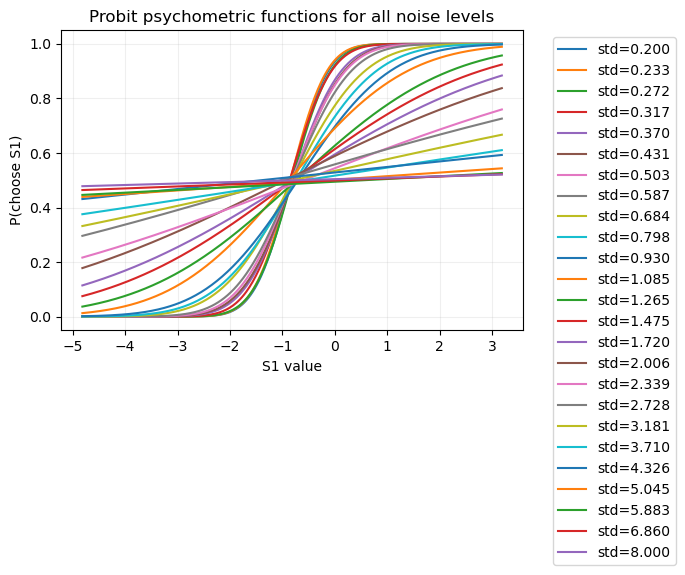

In [15]:
fit_results = []

global_xmin = df["S1_val"].min()
global_xmax = df["S1_val"].max()

unique_stds = sorted(df["S1_std"].unique())

plt.figure(figsize=(7, 5))

for std in unique_stds:
    block = df[df["S1_std"] == std].sort_values("S1_val")
    x = block["S1_val"].values.astype(float)
    p = block["P_choose1"].values.astype(float)
    n = block["N_trials"].values.astype(float)

    if (p <= 0).all() or (p >= 1).all():
        print(f"Skipping S1_std={std}: saturated responses.")
        continue

    idx50 = np.argmin(np.abs(p - 0.5))
    mu_init = x[idx50]
    sigma_init = 1.0  
    
    weights = np.sqrt(n)  

    try:
        (mu_hat, sigma_hat), pcov = curve_fit(
            cum_gauss,
            x,
            p,
            p0=[mu_init, sigma_init],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf]),
            sigma=1.0 / weights,   
            absolute_sigma=False,
            maxfev=20000,
        )
    except RuntimeError:
        print(f"[WARN] Probit fit failed for S1_std={std}")
        continue

    # Store results
    fit_results.append({
        "S1_std": std,
        "mu_hat": mu_hat,           
        "sigma_hat": sigma_hat,     
    })

    xx = np.linspace(global_xmin, global_xmax, 400)
    yy = cum_gauss(xx, mu_hat, sigma_hat)
    plt.plot(xx, yy, label=f"std={std:.3f}")

plt.xlabel("S1 value")
plt.ylabel("P(choose S1)")
plt.title("Probit psychometric functions for all noise levels")
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

slopes_df = pd.DataFrame(fit_results)
if slopes_df.empty:
    raise RuntimeError("No valid probit fits; cannot estimate prior variance.")

In [16]:
slopes_df = slopes_df.dropna(subset=["sigma_hat", "S1_std"]).copy()
slopes_df = slopes_df[(slopes_df["sigma_hat"] > 0) & (slopes_df["S1_std"] > 0)]

# Keep only mid-range sigmas (tune these)
SIGMA_MIN = 0.4   # too steep below this
SIGMA_MAX = 3.3   # too flat above this

good = (slopes_df["sigma_hat"] >= SIGMA_MIN) & (slopes_df["sigma_hat"] <= SIGMA_MAX)
slopes_clean = slopes_df[good].copy()

print(f"Using {len(slopes_clean)} blocks out of {len(slopes_df)} after sigma filter.")

Using 14 blocks out of 25 after sigma filter.


C_hat     = 0.14137400641688014
tau0_hat  = 4.22490851908305
sigma0²   = 0.23669151544541234

===== PRIOR VARIANCE ESTIMATE (THEORY FIT) =====
C_hat:        0.1414 ± 0.0169
tau_0:        4.2249 ± 1.5640 (95% CI [1.1594, 7.2904])
sigma_0²:     0.2367 ± 0.0876 (95% CI [0.0650, 0.4084])


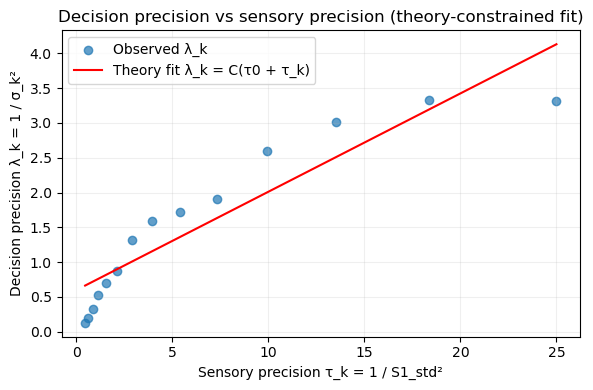

In [17]:



slopes_clean["lambda_hat"] = 1.0 / (slopes_clean["sigma_hat"]**2)
slopes_clean["tau_k"]      = 1.0 / (slopes_clean["S1_std"]**2)

x = slopes_clean["tau_k"].values
y = slopes_clean["lambda_hat"].values

def theory_lambda(tau_k, C, tau0):
    return C * (tau0 + tau_k)


C0    = (y[-1] - y[0]) / (x[-1] - x[0])
tau00 = 1.0

p0 = [C0, tau00]


(C_hat, tau0_hat), pcov = curve_fit(
    theory_lambda,
    x, y,
    p0=p0,
    bounds=([0.0, 0.0], [np.inf, np.inf])
)

sigma0_sq_hat = 1.0 / tau0_hat

print("C_hat     =", C_hat)
print("tau0_hat  =", tau0_hat)
print("sigma0²   =", sigma0_sq_hat)

# --- CIs from covariance ---
C_var, tau0_var = pcov[0,0], pcov[1,1]
C_se,  tau0_se  = np.sqrt(C_var), np.sqrt(tau0_var)

tau0_lo = tau0_hat - 1.96 * tau0_se
tau0_hi = tau0_hat + 1.96 * tau0_se

# propagate to sigma0² = 1 / tau0  via delta method
d_sig0sq_dtau0 = -1.0 / (tau0_hat**2)
sig0_var = (d_sig0sq_dtau0**2) * tau0_var
sig0_se  = np.sqrt(sig0_var)

sig0_lo = sigma0_sq_hat - 1.96 * sig0_se
sig0_hi = sigma0_sq_hat + 1.96 * sig0_se

print("\n===== PRIOR VARIANCE ESTIMATE (THEORY FIT) =====")
print(f"C_hat:        {C_hat:.4f} ± {C_se:.4f}")
print(f"tau_0:        {tau0_hat:.4f} ± {tau0_se:.4f} "
      f"(95% CI [{tau0_lo:.4f}, {tau0_hi:.4f}])")
print(f"sigma_0²:     {sigma0_sq_hat:.4f} ± {sig0_se:.4f} "
      f"(95% CI [{sig0_lo:.4f}, {sig0_hi:.4f}])")
print("================================================")

# --- Plot ---
tau_line = np.linspace(x.min(), x.max(), 200)
lambda_line = theory_lambda(tau_line, C_hat, tau0_hat)

plt.figure(figsize=(6,4))
plt.scatter(x, y, label="Observed λ_k", alpha=0.7)
plt.plot(tau_line, lambda_line, 'r', label="Theory fit λ_k = C(τ0 + τ_k)")
plt.xlabel("Sensory precision τ_k = 1 / S1_std²")
plt.ylabel("Decision precision λ_k = 1 / σ_k²")
plt.title("Decision precision vs sensory precision (theory-constrained fit)")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import numpy as np

N_BOOT = 1000
tau0_boot = []
sig0_boot = []

tau_k_all = slopes_clean["tau_k"].values
lambda_all = slopes_clean["lambda_hat"].values

for _ in range(N_BOOT):
    # resample indices of blocks with replacement
    idx = np.random.choice(len(tau_k_all), size=len(tau_k_all), replace=True)
    xb = tau_k_all[idx]
    yb = lambda_all[idx]

    try:
        (C_b, tau0_b), _ = curve_fit(
            theory_lambda,
            xb, yb,
            p0=[C_hat, tau0_hat],
            bounds=([0.0, 0.0], [np.inf, np.inf]),
            maxfev=20000
        )
    except RuntimeError:
        # skip failed fits
        continue

    tau0_boot.append(tau0_b)
    sig0_boot.append(1.0 / tau0_b)

tau0_boot = np.array(tau0_boot)
sig0_boot = np.array(sig0_boot)

tau0_mean = np.mean(tau0_boot)
sig0_mean = np.mean(sig0_boot)

tau0_ci = np.percentile(tau0_boot, [2.5, 97.5])
sig0_ci = np.percentile(sig0_boot, [2.5, 97.5])

print("\n===== BOOTSTRAP (BLOCK-LEVEL) =====")
print(f"tau_0:  mean={tau0_mean:.4f}, 95% CI [{tau0_ci[0]:.4f}, {tau0_ci[1]:.4f}]")
print(f"sigma0²: mean={sig0_mean:.4f}, 95% CI [{sig0_ci[0]:.4f}, {sig0_ci[1]:.4f}]")
print("===================================")


===== BOOTSTRAP (BLOCK-LEVEL) =====
tau_0:  mean=4.1001, 95% CI [1.0092, 7.8058]
sigma0²: mean=0.3255, 95% CI [0.1281, 0.9909]


In [19]:
slopes_df["tau_k"] = 1.0 / (slopes_df["S1_std"] ** 2)

print("\n===== PSYCHOMETRIC FIT RESULTS (VARIANCE EXP) =====")
print(slopes_df.sort_values("S1_std"))


===== PSYCHOMETRIC FIT RESULTS (VARIANCE EXP) =====
      S1_std    mu_hat  sigma_hat      tau_k
0   0.200000 -0.834398   0.549164  25.000000
1   0.233229 -0.855528   0.548267  18.383788
2   0.271979 -0.817889   0.575910  13.518547
3   0.317167 -0.863034   0.619961   9.940884
4   0.369862 -0.808596   0.722921   7.310044
5   0.431313 -0.800778   0.762292   5.375452
6   0.502973 -0.821060   0.794427   3.952847
7   0.586540 -0.810108   0.873564   2.906732
8   0.683990 -0.805910   1.070895   2.137470
9   0.797632 -0.745678   1.194520   1.571792
10  0.930154 -0.708601   1.373214   1.155819
11  1.084695 -0.878839   1.760627   0.849934
12  1.264911 -0.738159   2.276484   0.625000
13  1.475070 -0.808752   2.783221   0.459595
14  1.720145 -0.801993   3.334093   0.337964
15  2.005938 -0.945548   4.191237   0.248522
16  2.339214 -0.603068   5.371529   0.182751
17  2.727863 -1.045628   7.038501   0.134386
18  3.181083 -0.804789   9.241537   0.098821
19  3.709603 -0.568578  13.380851   0.072668
20

In [20]:
slopes_df["lambda_hat"] = 1.0 / (slopes_df["sigma_hat"] ** 2)

# keep only sane values
mask = np.isfinite(slopes_df["lambda_hat"]) & (slopes_df["lambda_hat"] > 0)
slopes_df = slopes_df[mask].copy()

x = slopes_df["tau_k"].values        # sensory precision
y = slopes_df["lambda_hat"].values   # decision precision

In [ ]:
X = np.vstack([x, np.ones_like(x)]).T  # design matrix
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
a, b = beta  

# residuals and noise variance estimate
y_pred = a * x + b
resid = y - y_pred
dof = len(x) - 2
sigma_eps2 = np.sum(resid**2) / dof

# covariance matrix of [a, b]
XtX_inv = np.linalg.inv(X.T @ X)
cov_beta = sigma_eps2 * XtX_inv
var_a  = cov_beta[0, 0]
var_b  = cov_beta[1, 1]
cov_ab = cov_beta[0, 1]

C_est      = a
tau0_est   = b / a                 
sigma0_sq_est = 1.0 / tau0_est     

d_tau0_da = -b / (a**2)
d_tau0_db =  1.0 / a

var_tau0 = (
    d_tau0_da**2 * var_a +
    d_tau0_db**2 * var_b +
    2 * d_tau0_da * d_tau0_db * cov_ab
)
se_tau0 = np.sqrt(var_tau0)

tau0_lo = tau0_est - 1.96 * se_tau0
tau0_hi = tau0_est + 1.96 * se_tau0

# Delta method for sigma0² = 1 / tau0
d_sig0sq_dtau0 = -1.0 / (tau0_est**2)
var_sig0_sq = (d_sig0sq_dtau0**2) * var_tau0
se_sigma0_sq = np.sqrt(var_sig0_sq)

sig0_lo = sigma0_sq_est - 1.96 * se_sigma0_sq
sig0_hi = sigma0_sq_est + 1.96 * se_sigma0_sq


===== PRIOR VARIANCE ESTIMATE (SLOPE-BASED) =====
a (slope C):            0.165184
b (intercept C*tau0):   0.246536
tau_0 (prior precision) = 1.492497 (95% CI [0.184190, 2.800803])
sigma_0² (prior var)    = 0.670018 (95% CI [0.082688, 1.257349])


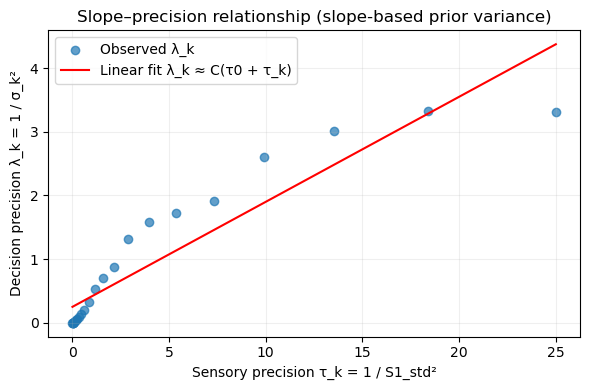

In [23]:

# ------------------------------------------
# Print results
# ------------------------------------------
print("===== PRIOR VARIANCE ESTIMATE (SLOPE-BASED) =====")
print(f"a (slope C):            {C_est:.6f}")
print(f"b (intercept C*tau0):   {b:.6f}")
print(f"tau_0 (prior precision) = {tau0_est:.6f} "
      f"(95% CI [{tau0_lo:.6f}, {tau0_hi:.6f}])")
print(f"sigma_0² (prior var)    = {sigma0_sq_est:.6f} "
      f"(95% CI [{sig0_lo:.6f}, {sig0_hi:.6f}])")
print("=================================================")

# ------------------------------------------
# Plot lambda_hat vs tau_k + regression line
# ------------------------------------------
tau_line = np.linspace(x.min(), x.max(), 200)
lambda_line = a * tau_line + b

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="Observed λ_k", alpha=0.7)
plt.plot(tau_line, lambda_line, "r", label="Linear fit λ_k ≈ C(τ0 + τ_k)")
plt.xlabel("Sensory precision τ_k = 1 / S1_std²")
plt.ylabel("Decision precision λ_k = 1 / σ_k²")
plt.title("Slope–precision relationship (slope-based prior variance)")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()